# **DATA PREPROCESSING BASED ON EDA INSIGHTS**

This notebook implements preprocessing steps based on the comprehensive EDA findings and recommendations. It follows the evidence-based approach from the EDA report to ensure our preprocessing aligns with the data patterns discovered.
Based on the EDA report, I will:

    ✅ Handled missing values properly.
    ✅ Handled the outliers.
    ✅ Handled the skewness.
    ✅ Created engineered features (TotalIncome, Log_TotalIncome, DTI, EMI, Flag).
    ✅ Encoded categorical variables.
    ✅ Scaled numeric data.
    ✅ Split dataset into training and testing subsets.

In [66]:
# let call all neccessary libraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stat 
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [67]:
# let load the data from EDA
df_process = pd.read_csv("EDA_data.csv")


## EDA_Based findings validation

In [68]:
df_process.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360,1,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360,1,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360,1,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360,1,Urban,Y
4,LP001011,Male,Yes,2,Graduate,Yes,5417.0,4196.0,267.0,360,1,Urban,Y


In [69]:
df_process.drop(columns="Loan_ID", inplace=True)

In [70]:
# let make a copy for preprocess
df= df_process.copy()

# check for missing values, it should be zero
print("")
print("--------------------------------")
print("Checking Missing Values")
print("--------------------------------")
missing_vals= df.isnull().sum()
if missing_vals.sum()>0:
    print(missing_vals[missing_vals>0])
else:
    print("No missing values as expected from EDA")

# check for duplicates
print("")
print("--------------------------------")
print("Checking duplicates rows")
print("--------------------------------")
duplicates=df.duplicated().sum()
if duplicates>0:
    print(f"The number of duplicate rows: {duplicates}")
    print(f"Percentage of duplicates:{duplicates/len(df)*100:.2f}%")

else:
    print(f"No duplicate rows")

# check skewness for the claimed variabled in EDA report as right skewed
print("")
print("--------------------------------")
print("Checking skewness of Features")
print("--------------------------------")

claimed_features=['ApplicantIncome','CoapplicantIncome','LoanAmount']
for col in claimed_features:
    skew_val= df[col].skew()
    print(f"{col} Skewness is: {skew_val:.2f}, ({"right-skewed" if skew_val > 0.5 else "approximately normal"})")




--------------------------------
Checking Missing Values
--------------------------------
No missing values as expected from EDA

--------------------------------
Checking duplicates rows
--------------------------------
No duplicate rows

--------------------------------
Checking skewness of Features
--------------------------------
ApplicantIncome Skewness is: 6.51, (right-skewed)
CoapplicantIncome Skewness is: 7.42, (right-skewed)
LoanAmount Skewness is: 2.65, (right-skewed)


## **Outlier Treatment**
IQR-capping for extreme Application Income, Coapplication Income and Loan amount

In [71]:
# let define fuction to do IQR Clipping
def IQR_Clipping(column):
    Q1= df[column].quantile(0.25)
    Q3= df[column].quantile(0.75)
    IQR= Q3-Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # get the number of capped outliers
    outliers_count= ((df[column]<lower) | (df[column]>upper)).sum()
    if outliers_count>0:
        df[column]= np.where(df[column]<lower,lower, np.where(df[column]>upper, upper, df[column]))
    
    print(f"\nTotal outliers capped for {column}: {outliers_count}")


In [72]:
for col in ['ApplicantIncome','CoapplicantIncome','LoanAmount']:
    IQR_Clipping(col)


Total outliers capped for ApplicantIncome: 48

Total outliers capped for CoapplicantIncome: 18

Total outliers capped for LoanAmount: 39


## Handle Skewed Variables



In [73]:
# As suggested from EDA, we are using log transform bcus it is right skewed
# Log-transform skewed variables(e.g.,ApplicationIncome CoapplicationIncome and Loanamount).
df["ApplicantIncome"]= np.log1p(df["ApplicantIncome"])
df["CoapplicantIncome"]= np.log1p(df["CoapplicantIncome"])
df["LoanAmount"]= np.log1p(df["LoanAmount"])

## **Feature Engineering** - Create and interaction features

-   Total Income (TotalIncome = ApplicantIncome + CoapplicantIncome)
-   Debt-to-Income Ratio (DTI = LoanAmount / TotalIncome)
-   Equated Monthly Instalment Feature (EMI = LoanAmount / Loan_Amount_Term)

In [74]:
# total income
df["TotalIncome"]= df["ApplicantIncome"] + df["CoapplicantIncome"]

# Debt to income ratio (DTI)
df["DTI"]= df["LoanAmount"] / df["TotalIncome"]

# Equated Monthly Instalment (EMI)
df["EMI"]= df["LoanAmount"]/ df["Loan_Amount_Term"]

engineered_features=["TotalIncome","DTI", "EMI"]

In [75]:
# let get our numerical column before label encoding
num_cols= df.select_dtypes(include="number").columns
num_cols

Index(['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'DTI', 'EMI'],
      dtype='object')


## **Encoded categorical variables.**

In [76]:
# let encode our categorical feature into numerical.
categorical_col= df.select_dtypes(include="object").columns
categorical_col

Index(['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area',
       'Loan_Status'],
      dtype='object')

I will be doing label encoding for binary column and One-hot encoding for multi-category column

In [77]:
# label encoding
le= LabelEncoder()


binary_col=['Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Status']
for col in binary_col:
    df[col]=le.fit_transform(df[col])

# OneHotEncoding for multi-category

df = pd.get_dummies(df,columns=["Property_Area"], drop_first=True)

# let see whats up
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,DTI,EMI,Property_Area_Semiurban,Property_Area_Urban
0,1,1,1,0,0,8.430327,7.319202,4.859812,360,1,0,15.749530,0.308569,0.013499,False,False
1,1,1,0,0,1,8.006701,0.000000,4.204693,360,1,1,8.006701,0.525147,0.011680,False,True
2,1,1,0,1,0,7.857094,7.765993,4.795791,360,1,1,15.623087,0.306968,0.013322,False,True
3,1,0,0,0,0,8.699681,0.000000,4.955827,360,1,1,8.699681,0.569656,0.013766,False,True
4,1,1,2,0,1,8.597482,8.342125,5.590987,360,1,1,16.939607,0.330054,0.015531,False,True


## **Scaled numeric data.**

In [78]:
num_cols

Index(['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'DTI', 'EMI'],
      dtype='object')

In [79]:
# let normalize numeric values to help algorithms like Logistic Regression or SVM perform better.

scaler= StandardScaler()
df[num_cols]= scaler.fit_transform(df[num_cols])
df[num_cols].std()

Dependents           1.000866
ApplicantIncome      1.000866
CoapplicantIncome    1.000866
LoanAmount           1.000866
Loan_Amount_Term     1.000866
Credit_History       1.000866
TotalIncome          1.000866
DTI                  1.000866
EMI                  1.000866
dtype: float64

In [80]:
# let see whats up
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,DTI,EMI,Property_Area_Semiurban,Property_Area_Urban
0,1,1,0.241328,0,0,0.239537,0.788442,0.028269,0.273068,0.533333,0,0.860691,-0.871572,-0.143847,False,False
1,1,1,-0.747945,0,1,-0.534568,-1.113273,-1.411882,0.273068,0.533333,1,-1.244501,0.812283,-0.243029,False,True
2,1,1,-0.747945,1,0,-0.807949,0.904530,-0.112470,0.273068,0.533333,1,0.826312,-0.884016,-0.153540,False,True
3,1,0,-0.747945,0,0,0.731735,-1.113273,0.239338,0.273068,0.533333,1,-1.056087,1.158335,-0.129311,False,True
4,1,1,1.230600,0,1,0.544983,1.054224,1.635612,0.273068,0.533333,1,1.184260,-0.704527,-0.033152,False,True


## Feature Selection

In [81]:
# let see the correlation again with encoded categorical labell included
corr = df.corr()['Loan_Status'].abs().sort_values(ascending=False)
print(corr)

Loan_Status                1.000000
Credit_History             0.410319
Property_Area_Semiurban    0.124514
Married                    0.096014
DTI                        0.075196
Education                  0.068168
TotalIncome                0.057002
CoapplicantIncome          0.053058
LoanAmount                 0.044991
Loan_Amount_Term           0.029979
Gender                     0.028282
Dependents                 0.027230
Property_Area_Urban        0.026600
Self_Employed              0.018693
ApplicantIncome            0.009948
EMI                        0.001663
Name: Loan_Status, dtype: float64


In [82]:
# As evidence from EDA,  Credit_History is the only feature that gives 
# a moderate or useful signal for predicting Loan Status.

# using the whole data set let select feature with correlation of >0.05 with the target
selected_features= corr[corr>0.05].index.tolist()
selected_features.remove('Loan_Status') # Not to include the target
no_selected_feature=len(selected_features)
print("Total no of features(Encoding & Engineered):",len(df.columns) )
print("No of features selected:",no_selected_feature )
print("No of features to discard (low correlations):", len(df.columns) - no_selected_feature)
print("selected_features are:", selected_features)
df[selected_features].head(2)





Total no of features(Encoding & Engineered): 16
No of features selected: 7
No of features to discard (low correlations): 9
selected_features are: ['Credit_History', 'Property_Area_Semiurban', 'Married', 'DTI', 'Education', 'TotalIncome', 'CoapplicantIncome']


,Credit_History,Property_Area_Semiurban,Married,DTI,Education,TotalIncome,CoapplicantIncome
0,0.533333,False,1,-0.871572,0,0.860691,0.788442
1,0.533333,False,1,0.812283,0,-1.244501,-1.113273


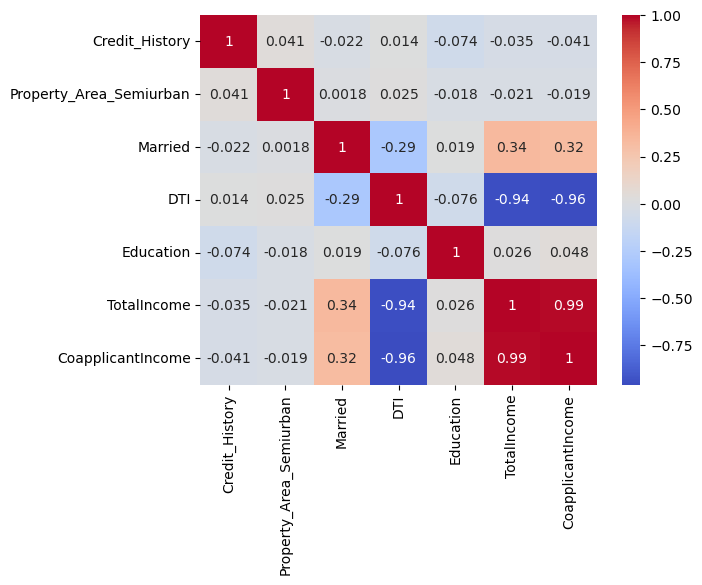

In [83]:
# for multicollinearity check
sns.heatmap(df[selected_features].corr(), annot=True, cmap="coolwarm")
plt.show()

## **Split dataset into training and testing subsets.**

In [84]:
X= df[selected_features]
y=df["Loan_Status"]

In [85]:
# let split our dataset
# first level split temp and test
X_temp, X_test, y_temp, y_test= train_test_split(X,y, stratify=y, test_size=0.2, random_state=234)

# second level train_test_split
X_train, X_val, y_train, y_val= train_test_split(X_temp,y_temp, test_size=0.25, stratify=y_temp, random_state=234)

print ("======= Data split result ========")
print(f"Training set: {X_train.shape} ({(X_train.shape[0]/len(X))*100:.1f}%)")
print(f"Validation set: {X_val.shape} ({(X_val.shape[0]/len(X))*100:.1f}%)")
print(f"Test set: {X_test.shape} ({(X_test.shape[0]/len(X))*100:.1f}%)")


======= Data split result ========
Training set: (346, 7) (59.9%)
Validation set: (116, 7) (20.1%)
Test set: (116, 7) (20.1%)


## **Feature Importance Analysis**

=== FEATURE IMPORTANCE ANALYSIS ===
Top 10 features by correlation with quality:
 1. Credit_History: 0.433
 2. Property_Area_Semiurban: 0.115
 3. Married: 0.102
 4. DTI: 0.041
 5. TotalIncome: 0.024
 6. CoapplicantIncome: 0.014
 7. Education: 0.000

 Engineered features in top 10: ['TotalIncome', 'DTI']


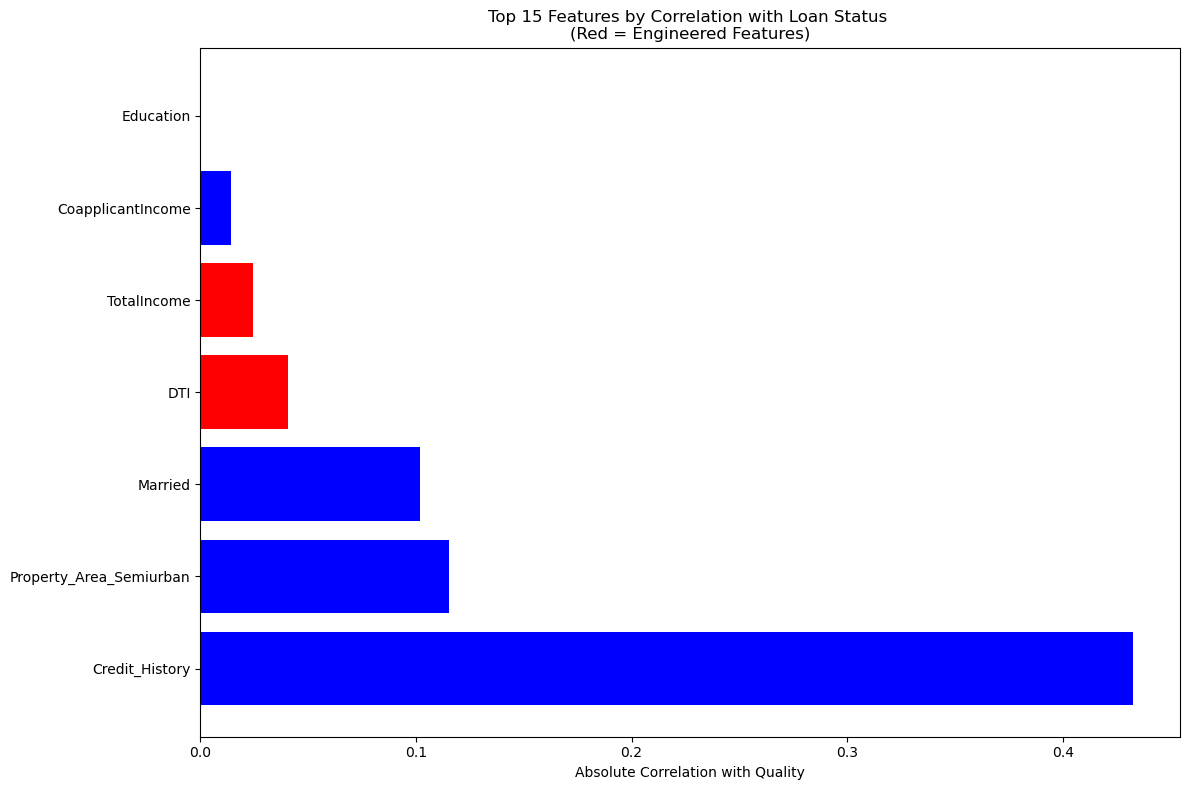

In [86]:
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# correlation with target for all features
feature_corelations = X_train.corrwith(y_train).abs().sort_values(ascending=False)

print("Top 10 features by correlation with quality:")
for i, (feature, corr) in enumerate(feature_corelations.head(10).items(),1):
    print(f"{i:2d}. {feature}: {corr:.3f}")
print(f"\n Engineered features in top 10: {[f for f in engineered_features if f in feature_corelations.head(10).index]}")

# visulize the feaature importance
plt.figure(figsize=(12,8))
top_features= feature_corelations.head(15)
colors = ['red' if f in engineered_features else 'blue' for f in top_features.index]
plt.barh(range(len(top_features)),top_features.values, color=colors)
plt.yticks(range(len(top_features)),top_features.index)
plt.xlabel('Absolute Correlation with Quality')
plt.title('Top 15 Features by Correlation with Loan Status \n(Red = Engineered Features)')
# plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## **11. Save Preprocessed Data**

In [87]:
# Save split datasets
X_train.to_csv('X_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)


# Save target variables
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Save preprocessing objects
joblib.dump(selected_features, 'selected_features.pkl')

# Save preprocessing summary
preprocessing_summary = {
    'original_shape': df_process.shape,
    'final_shape': df.shape,
    'selected_features': selected_features,
    'engineered_features': engineered_features,
    'train_samples': X_train.shape[0],
    'val_samples': X_val.shape[0],
    'test_samples': X_test.shape[0],
    'scaling_method': 'StandardScaler',
    'outlier_treatment': 'IQR_capping',
    'log_transformed': ['ApplicantIncome','CoapplicantIncome','LoanAmount']
}


with open('preprocessing_summary.json', 'w') as f:
    json.dump(preprocessing_summary, f, indent=2)

print("- Preprocessed data saved successfully!")
print("\nFiles created:")
print("- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv")
print("- y_train.csv, y_val.csv, y_test.csv")
print("- selected_features.pkl")
print("- feature_importance.csv, preprocessing_summary.json")


- Preprocessed data saved successfully!

Files created:
- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv
- y_train.csv, y_val.csv, y_test.csv
- selected_features.pkl
- feature_importance.csv, preprocessing_summary.json
